## Logistic Regression

### 1. Imports

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix
)

import matplotlib.pyplot as plt
from sklearn.utils import class_weight

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### 2. Load Data

In [6]:
DATA_PATH = "user_level_data.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (20011, 31)


,userId,y_active,province,age_gender_missing,followCnt_log,usr_actions_taken,usr_like_rate,usr_share_rate,usr_comment_rate,usr_ever_inthomeviewed,...,usr_only_click,usr_shared_x_liked,usr_shared_x_commented,usr_intohome_x_liked,avg_pop_index_pca,avg_content_pop_index,avg_pop_rank_exposure_row,avg_publishTime,max_creator_pop_index,entropy_pca
0,ICKCJCGCLCNCGCGCKC,0,hu nan,1,1.386294,1,0.0,0.0,0.0,0,...,1,0,0,0,2.256422,0.480290,1.180628,48.0,2.267234,-1.386364
1,ICKCMCHCJCKCJCGCJC,0,zhe jiang,1,1.791759,2,0.0,0.0,0.0,0,...,1,0,0,0,2.165059,1.093780,8.046991,99.5,5.094943,0.651362
2,ICMCICMCNCPCHCHCMC,0,jiang su,1,1.386294,2,0.0,0.0,0.0,0,...,1,0,0,0,3.397417,2.701646,1.068567,96.5,3.110753,0.651362
3,ICMCKCICKCPCLCKCOC,0,hu bei,1,1.609438,1,0.0,0.0,0.0,0,...,1,0,0,0,2.986094,0.246192,0.690827,26.0,1.754445,-1.386364
4,ICNCICLCICPCLCICOC,0,hu bei,1,1.386294,1,0.0,0.0,0.0,0,...,1,0,0,0,-2.020242,0.186663,0.155595,164.0,-0.820520,-1.386364


### 3. Preprocessing

In [7]:
# Drop leakage columns (adjust this if needed)
drop_cols = ["userId"] if "userId" in df.columns else []
df = df.drop(columns=drop_cols, errors="ignore")

# Target
TARGET_COL = "y_active"
y = df[TARGET_COL].astype(int).values
X = df.drop(columns=[TARGET_COL])

# One-hot encode categorical variables
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

feature_names = X.columns.tolist()
print(f"Final number of features: {len(feature_names)}")

Final number of features: 62


### 4. Train-Test Split

In [8]:
# 80/20 Train–Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Train:", X_train.shape)
print("Test: ", X_test.shape)

Train: (16008, 62)
Test:  (4003, 62)


### 5. Scaling

In [9]:
# Scaling (fit only on training data)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


### 6. Model Training

In [10]:
# Class imbalance handling via class weights
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
cw = {i: w for i, w in enumerate(cw)}

logreg = LogisticRegression(
    solver="liblinear",
    class_weight=cw,
    max_iter=500
)

logreg.fit(X_train_s, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{0: np.float64(0.7031538258806993), 1: np.float64(1.7305945945945946)}"
,random_state,None
,solver,'liblinear'
,max_iter,500
,multi_class,'deprecated'


### 7. Threshold Optimization (Youden + F1)

In [11]:
train_proba = logreg.predict_proba(X_train_s)[:, 1]
train_auc   = roc_auc_score(y_train, train_proba)
train_pr    = average_precision_score(y_train, train_proba)

print("\nTRAINING PERFORMANCE (for threshold selection)")
print("---------------------------------------------")
print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Train PR-AUC:  {train_pr:.4f}")

# Youden J on training set
fpr, tpr, thr = roc_curve(y_train, train_proba)
youden = tpr - fpr
thr_youden = thr[np.argmax(youden)]

# F1 threshold on training set
prec, rec, thr2 = precision_recall_curve(y_train, train_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_f1 = thr2[np.argmax(f1_scores)]

print("\nOptimal threshold (Youden J):", round(thr_youden, 3))
print("Optimal threshold (F1):       ", round(thr_f1, 3))

# Use F1-optimised threshold as final
final_threshold = float(thr_f1)



TRAINING PERFORMANCE (for threshold selection)
---------------------------------------------
Train ROC-AUC: 0.9261
Train PR-AUC:  0.7708

Optimal threshold (Youden J): 0.438
Optimal threshold (F1):        0.484


### 8. Evaluation on TEST SET


TEST SET PERFORMANCE
----------------------
Threshold:   0.484
Accuracy:    0.8549
Precision:   0.6729
Recall:      0.9680
F1 Score:    0.7939
ROC-AUC:     0.9281
PR-AUC:      0.7766

Confusion Matrix:
              Inactive (0)  Active (1)
Inactive (0)          2303         544
Active (1)              37        1119


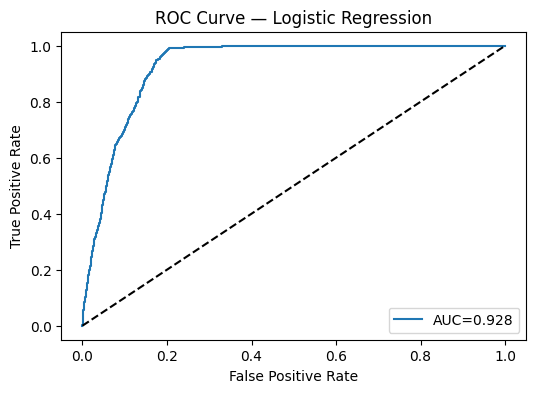

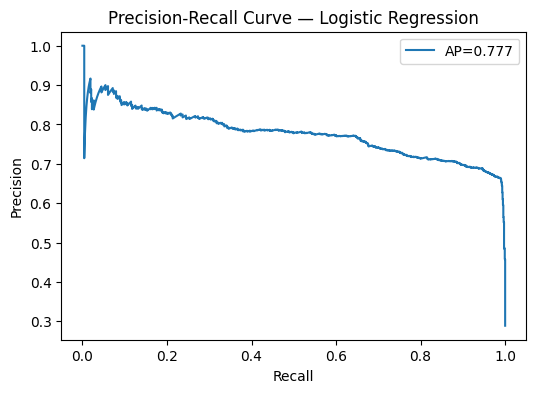

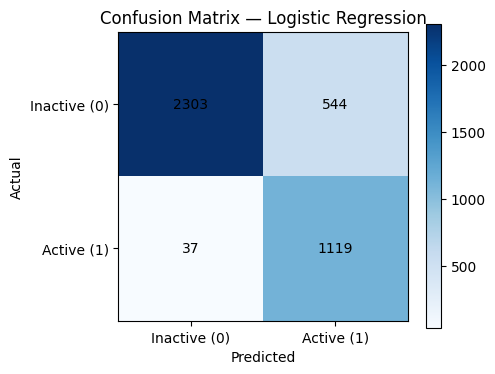

In [12]:
test_proba = logreg.predict_proba(X_test_s)[:, 1]
test_pred  = (test_proba >= final_threshold).astype(int)

acc       = accuracy_score(y_test, test_pred)
prec_test = precision_score(y_test, test_pred)
rec_test  = recall_score(y_test, test_pred)
f1        = f1_score(y_test, test_pred)
auc_test  = roc_auc_score(y_test, test_proba)
pr_test   = average_precision_score(y_test, test_proba)

cm = confusion_matrix(y_test, test_pred)
cm_labels = ["Inactive (0)", "Active (1)"]

print("\nTEST SET PERFORMANCE")
print("----------------------")
print(f"Threshold:   {final_threshold:.3f}")
print(f"Accuracy:    {acc:.4f}")
print(f"Precision:   {prec_test:.4f}")
print(f"Recall:      {rec_test:.4f}")
print(f"F1 Score:    {f1:.4f}")
print(f"ROC-AUC:     {auc_test:.4f}")
print(f"PR-AUC:      {pr_test:.4f}")

print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=cm_labels, columns=cm_labels))

# ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr_test, tpr_test, label=f"AUC={auc_test:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.show()

# PR Curve
prec_test_vals, rec_test_vals, _ = precision_recall_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(rec_test_vals, prec_test_vals, label=f"AP={pr_test:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Logistic Regression")
plt.legend()
plt.show()

# Confusion Matrix Visualization
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, cm_labels)
plt.yticks(tick_marks, cm_labels)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### 9. FEATURE IMPORTANCE 


TOP 20 MOST IMPORTANT FEATURES
                       feature  coefficient  importance
2            usr_actions_taken     2.562275    2.562275
12  usr_followlog_x_actionrate     1.312787    1.312787
10  usr_sum_isLike_x_followlog    -1.008195    1.008195
18              usr_only_click    -0.941070    0.941070
1                followCnt_log    -0.691941    0.691941
3                usr_like_rate     0.584814    0.584814
14               usr_avg_dwell     0.533407    0.533407
15            usr_avg_position     0.195607    0.195607
22           avg_pop_index_pca    -0.189306    0.189306
16             usr_active_days     0.170217    0.170217
7              usr_ever_shared    -0.162424    0.162424
8           usr_ever_commented    -0.157825    0.157825
6       usr_ever_inthomeviewed     0.154180    0.154180
4               usr_share_rate     0.128967    0.128967
20      usr_shared_x_commented     0.124096    0.124096
26       max_creator_pop_index     0.102791    0.102791
24   avg_pop_ran

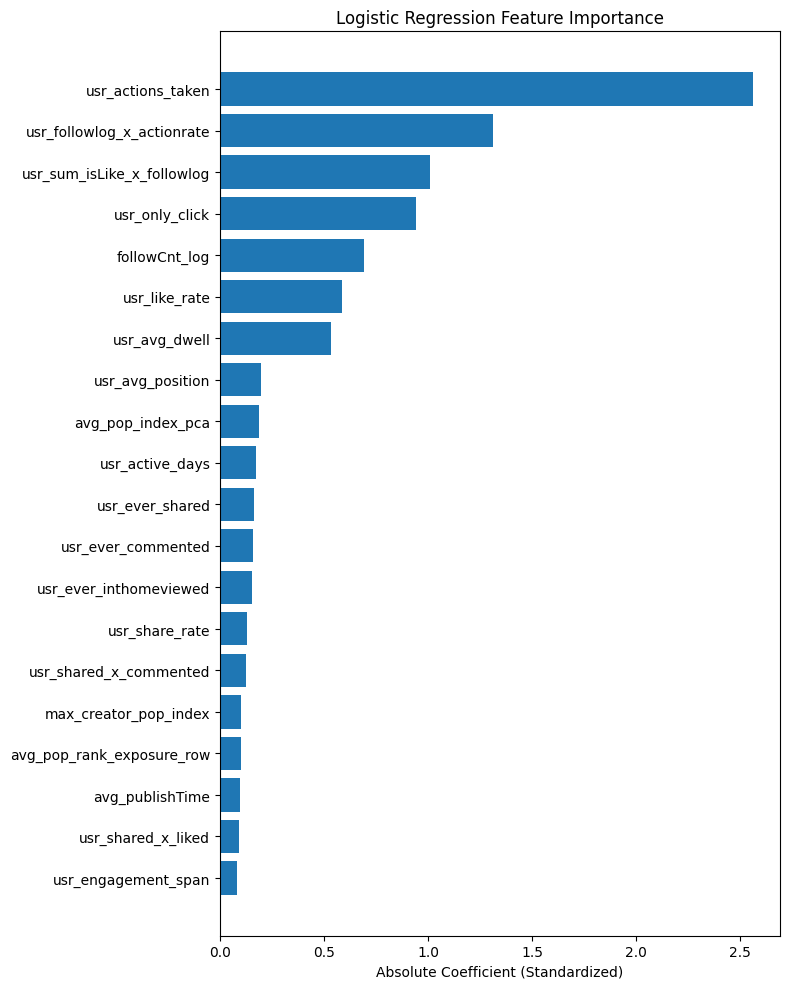

In [13]:
# Absolute standardized coefficients
coef = logreg.coef_[0]

# Because coefficients were fitted on scaled features,
# their magnitudes are directly comparable.
importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef,
    "importance": np.abs(coef)
})

# Sort by absolute importance
importance_df = importance_df.sort_values("importance", ascending=False)

print("\nTOP 20 MOST IMPORTANT FEATURES")
print(importance_df.head(20))

# Optional: Plot
plt.figure(figsize=(8, 10))
plt.barh(
    importance_df.head(20)["feature"][::-1],
    importance_df.head(20)["importance"][::-1]
)
plt.xlabel("Absolute Coefficient (Standardized)")
plt.title("Logistic Regression Feature Importance")
plt.tight_layout()
plt.show()
